# 01: Sampling

This notebook locates and samples plots, exporting an HDF5 dataset with arrays of LiDAR metrics and NAIP reflectance values for each plot footprint.

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import ee

from naip_cnn import sampling
from naip_cnn.config import CRS

# ee.Authenticate()
ee.Initialize()

Before continuing, we'll specify a minimum spacing between footprints in meters and a projection.

In [10]:
MIN_SPACING = 150
PROJ = ee.Projection(CRS)
DATASET_NAME = "MAL2016_CanyonCreek"
NAIP_YEAR = 2016
FOOTPRINT_SIZE = (150, 150)
FILE_NAME = f"{DATASET_NAME}_{FOOTPRINT_SIZE[0]}x{FOOTPRINT_SIZE[1]}"

## Load Data

Our training data will be a set of points with 1) LiDAR attributes for prediction and 2) corresponding NAIP reflectance values. Both will ultimately be stored as co-located 2D arrays of pixel values at footprint locations. 

The first step will be to load a LiDAR image and a coincident NAIP mosaic and reproject them to a consistent projection.

In [4]:
lidar = ee.Image(
    f"projects/ee-maptheforests/assets/malheur_lidar/{DATASET_NAME}"
).reproject(PROJ.atScale(30))

naip = (
    ee.ImageCollection("USDA/NAIP/DOQQ")
    .filterDate(str(NAIP_YEAR), str(NAIP_YEAR + 1))
    .filterBounds(lidar.geometry().bounds())
    .mosaic()
    .reproject(PROJ.atScale(1))
)

## Generate Sample Footprints

We'll extract data across a collection of footprints. To begin, we'll distribute points across the LiDAR image with a minimum spacing.

In [5]:
samples = lidar.sample(
    scale=MIN_SPACING, projection=PROJ, factor=1.0, dropNulls=True, geometries=True
)

We can check `samples.size` to figure out how many non-masked pixels were sampled at the given spacing.

In [6]:
samples.size().getInfo()

370435

Next, we'll convert our collection of sample points to square footprints with a given size.

In [7]:
footprints = samples.map(
    lambda p: sampling.point_to_footprint(p, dims=FOOTPRINT_SIZE, proj=PROJ)
)

## Extract Pixel Values

With our footprints defined, we can extract arrays of pixel values from the LiDAR and NAIP images.

In [8]:
footprints = footprints.map(
    lambda f: sampling.extract_values_at_footprint(f, img=lidar, proj=PROJ, scale=30),
    opt_dropNulls=True,
).map(
    lambda f: sampling.extract_values_at_footprint(f, img=naip, proj=PROJ, scale=1),
    opt_dropNulls=True,
)

## Export to Drive

Extracting large numbers of pixel values across footprints is memory- and time-intensive, so we'll need to export the data to Drive rather than directly accessing it client-side. This process can take a while, and progress can be monitored in the [task manager](https://code.earthengine.google.com/tasks).

***Note**: Make sure you're authenticated with the correct Earth Engine account, as this will determine the Drive to which data is exported.*

In [9]:
task = ee.batch.Export.table.toDrive(
    collection=footprints,
    description=FILE_NAME,
)

task.start()

## Convert CSV To HDF5

*Once the export task is complete*, you'll need to download the resulting CSV file to local storage. 

The CSV format exported by Earth Engine is not optimized for training, so we'll need to convert it to an HDF5 file. In the process, we'll reshape the pixel arrays, which are currently stored as comma-separated strings, into 2D arrays.

In [3]:
from dask.distributed import Client
import dask.dataframe as dd
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

We'll use Dask to parallelize the loading and processing steps. Creating a local Dask client will allow us to monitor progress in the Dask dashboard.

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.27 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45487,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.27 GiB
Comm: tcp://127.0.0.1:39967,Total threads: 2
Dashboard: http://127.0.0.1:44907/status,Memory: 7.82 GiB
Nanny: tcp://127.0.0.1:35041,


Load the CSV file as a deferred Dask dataframe. You'll see that it includes columns for each of the NAIP bands, LiDAR attributes, and a few other metadata columns.

In [32]:
df = dd.read_csv(f"../data/training/{FILE_NAME}.csv")
df

,system:index,B,G,N,R,cover,height,rh100,rh25,rh50,rh95,width,.geo
npartitions=184,,,,,,,,,,,,,
,int64,object,object,object,object,object,int64,object,object,object,object,int64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


Next, we'll parse the 1D strings into 2D arrays. We'll stack the NAIP arrays into a single `image` column, while each of the LiDAR labels will be kept in its own column, allowing us to easily train on a single label.

In [33]:
df["image"] = df.apply(
    sampling.parse_pixel_array,
    shape=(150, 150),
    col=("R", "G", "B", "N"),
    axis=1,
    meta=pd.Series(dtype=np.uint8),
)

for label in ("cover", "rh25", "rh50", "rh95", "rh100"):
    df[label] = df.apply(
        sampling.parse_pixel_array,
        shape=(5, 5),
        col=label,
        axis=1,
        meta=pd.Series(dtype=np.float32),
    )

Now, we can drop the unused columns.

In [34]:
df = df.drop(columns=["R", "G", "B", "N", ".geo", "height", "width", "system:index"])

Finally, we'll compute the dataframe and save it as an HDF5 file. This will take a few minutes.

In [35]:
df = df.compute()

In [39]:
with h5py.File(f"../data/training/{FILE_NAME}.h5", "w") as f:
    for var in ("image", "cover", "rh25", "rh50", "rh95", "rh100"):
        f.create_dataset(var, data=np.stack(df[var].values), compression="gzip")

Just to get an idea of the data we'll be training with, we can plot a few footprints.

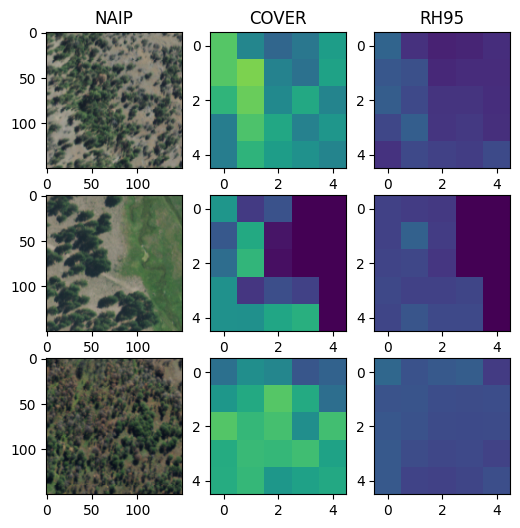

In [40]:
n = 3
check_footprints = df.sample(n=n, random_state=99)

fig, ax = plt.subplots(n, 3, figsize=(6, n * 2))
for i in range(n):
    ax[i, 0].imshow(check_footprints["image"].values[i][:, :, :3])
    ax[i, 1].imshow(check_footprints["cover"].values[i], vmin=0, vmax=100)
    ax[i, 2].imshow(check_footprints["rh95"].values[i], vmin=0, vmax=100)

ax[0, 0].set_title("NAIP")
ax[0, 1].set_title("COVER")
ax[0, 2].set_title("RH95");